In [1]:
# RSI PowerZone Weekly
import indicator
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import prices
import trade_statistics
from plotly.subplots import make_subplots

In [2]:
# Trade parameters.
exchange = 'LSE'
tidm = 'SMS'
timeframe = 'Weekly'
filename = f'{exchange}_{tidm}_prices.csv'
history_start = '2003-03-19'
history_end = '2021-09-24'
p_sma = 40  # Simple Moving Average (SMA) look back period.
p_rsi = 4  # Relative Strength Index (RSI) look back period.
pz1 = 30  # First RSI PowerZone entry level.
pz2 = 25  # Second RSI PowerZone entry level.
pze = 75  # RSI PowerZone exit level.
position_size = 10000  # Position size in major currency unit.
charges = 6  # Commission per trade (round trip).
stamp_duty = 0.0  # Stamp Duty percentage.
stop_loss = 20  # Stop Loss percentage.

In [3]:
def state_signal(entry_signal, exit_signal, period):
    '''Calculate trade state signals.'''
    df = pd.concat([entry_signal, exit_signal], axis=1)
    df.columns = ['entry', 'exit']
    df['state'] = 0
    for i in range(period, len(df)):
        if df.loc[df.index[i], 'entry'] == 1 \
        and df.loc[df.index[i - 1], 'state'] == 0:
            df.loc[df.index[i], 'state'] = 1
        elif df.loc[df.index[i], 'exit'] == 1:
            df.loc[df.index[i], 'state'] = 0
        else:
            df.loc[df.index[i], 'state'] = df.loc[df.index[i - 1], 'state']
    return df.state


def trade_list(close, entry_flag, exit_flag):
    '''Generate trade list.'''
    ref = pd.concat([close, entry_flag, exit_flag], axis=1)
    ref.columns = ['close', 'entry_flag', 'exit_flag']
    df = pd.DataFrame(columns=['entry_price', 'exit_date', 'exit_price'])
    df.entry_price = ref.close[ref.entry_flag == 1]
    df.exit_date = ref.index[ref.exit_flag == 1]
    df.exit_price = ref.close[ref.exit_flag == 1].values
    return df

In [4]:
# Import weekly closing prices.
df = prices.weekly(exchange, tidm, history_start, history_end)

In [5]:
# Simple moving average (SMA).
df['sma'] = df.close.rolling(p_sma).mean()
sma = df.sma

# Relative Strength Index (RSI).
df['rsi'] = indicator.rsi(df.close, p_rsi)

In [6]:
# Check closing price is above SMA.
df['trend'] = np.where(df.close > df.sma, 1, 0)

# Check for RSI cross below first PowerZone.
df['pz1'] = np.where(np.logical_and(
        df.rsi.shift(periods=1) >= pz1, df.rsi < pz1), 1, 0)

# Check whether RSI is below second PowerZone and price is above SMA.
df['pz2'] = np.where(np.logical_and(df.trend == 1, df.rsi < pz2), 1, 0)

# Check for RSI cross above exit level.
df['pze'] = np.where(np.logical_and(
    df.rsi.shift(periods=1) < pze, df.rsi >= pze), 1, 0)

# Trade #1 entry signal.
df['sig1'] = np.where(np.logical_and(df.trend == 1, df.pz1 == 1), 1, 0)

# Trade #1 state signal.
df['ss1'] = state_signal(df.sig1, df.pze, p_sma)

# Trade #2 entry signal.
df['sig2'] = np.where(np.logical_and(
    df.ss1.shift(periods=1) == 1, df.pz2 == 1), 1, 0)

# Trade #2 state signal.
df['ss2'] = state_signal(df.sig2, df.pze, p_sma)

# Trade entry & exit flags.
df['en1'] = np.where(np.logical_and(
    df.ss1 == 1, df.ss1.shift(periods=1) == 0), 1, 0)
df['ex1'] = np.where(np.logical_and(
    df.ss1 == 0, df.ss1.shift(periods=1) == 1), 1, 0)
df['en2'] = np.where(np.logical_and(
    df.ss2 == 1, df.ss2.shift(periods=1) == 0), 1, 0)
df['ex2'] = np.where(np.logical_and(
    df.ss2 == 0, df.ss2.shift(periods=1) == 1), 1, 0)

In [7]:
# Trade list based on RSI exit only (no Stop Loss).
td1 = trade_list(df.close, df.en1, df.ex1)  # Trade List #1.
td2 = trade_list(df.close, df.en2, df.ex2)  # Trade List #2.
td = pd.concat([td1, td2])  # Create full trade list.
td = td.sort_index()  # Sort trades in ascending date order.

# Append trade percentage price change to trade list.
td['chg_pct'] = ((td.exit_price - td.entry_price) / td.entry_price) * 100

In [8]:
# Trade list incorporating Stop Loss.
tdm = pd.DataFrame(columns=['entry_price', 'exit_date', 'exit_price'])
tdm.entry_price = td.entry_price
tdm.exit_date = td.exit_date
tdm.exit_price = td.exit_price

for i in range(0, len(td)):
    # Loop through trade list based on RSI exit and check if stop is triggered.
    ps = pd.DataFrame(columns=['close', 'stop', 'exit'])
    ps.close = df.close.loc[td.index[i]: td.exit_date[i]]
    ps.stop = ps.close[0] * (1 - (stop_loss / 100))
    ps.exit = np.where(ps.close < ps.stop, 1, 0)

    # Create modified trade list incorporating Stop Loss.
    if ps.exit.sum() > 0:
        exit_date = ps.exit.idxmax(axis=1, skipna=True)
        tdm.loc[tdm.index[i], 'exit_date'] = exit_date
        tdm.loc[tdm.index[i], 'exit_price'] = ps.close.loc[exit_date]
    else:
        tdm.loc[tdm.index[i], 'exit_date'] = td.loc[td.index[i], 'exit_date']
        tdm.loc[tdm.index[i], 'exit_price'] = td.loc[td.index[i], 'exit_price']

# Cumulative profit after costs.
tdm['weeks'] = (tdm.exit_date - tdm.index) / np.timedelta64(1, 'W')
tdm['chg_pct'] = ((tdm.exit_price - tdm.entry_price) / tdm.entry_price) * 100
tdm['charges'] = charges
tdm['stamp_duty'] = position_size * (stamp_duty / 100)
tdm['profit'] = position_size * \
    (tdm.chg_pct / 100) - tdm.charges - tdm.stamp_duty
tdm['cum_profit'] = tdm.profit.cumsum()
cum_profit = tdm.cum_profit
tdm.round(2)

,entry_price,exit_date,exit_price,weeks,chg_pct,charges,stamp_duty,profit,cum_profit
date,,,,,,,,,
2013-02-15,2.17,2013-05-03,2.65,11.0,21.84,6,0.0,2177.91,2177.91
2013-02-22,2.15,2013-05-03,2.65,10.0,23.26,6,0.0,2319.58,4497.49
2013-10-25,3.26,2014-01-10,3.38,11.0,3.69,6,0.0,362.66,4860.15
2013-11-08,3.22,2014-01-10,3.38,9.0,4.98,6,0.0,491.67,5351.82
2017-03-24,5.68,2017-07-21,5.86,17.0,3.26,6,0.0,319.99,5671.81
2017-04-28,5.52,2017-07-21,5.86,12.0,6.16,6,0.0,609.94,6281.75
2017-11-17,7.18,2017-12-29,8.74,6.0,21.88,6,0.0,2182.15,8463.91
2018-02-02,7.33,2018-04-20,8.01,11.0,9.28,6,0.0,921.69,9385.60
2018-02-09,6.94,2018-04-20,8.01,10.0,15.42,6,0.0,1535.79,10921.39


In [9]:
# Trade statistics.
ts = trade_statistics.summary(tidm, sma, position_size, tdm)
ts

TIDM                               SMS
Start Date                  2012-04-06
End Date                    2021-09-24
Analysis Years                     9.5
Position Size                10,000.00
Net Profit                   12,134.47
Annual %                           8.7
Charges                          60.00
Stamp Duty                        0.00
Total Trades                        10
Winning Trades                      10
Losing Trades                        0
Winning %                        100.0
Trades per Year                    1.1
Average Profit %                  12.2
Average Profit                1,213.45
Average Weeks                     12.0
Average Winning Profit %          12.2
Average Winning Profit        1,213.45
Average Winning Weeks             12.0
Average Losing Profit %            nan
Average Losing Profit              nan
Average Losing Weeks               nan
dtype: object

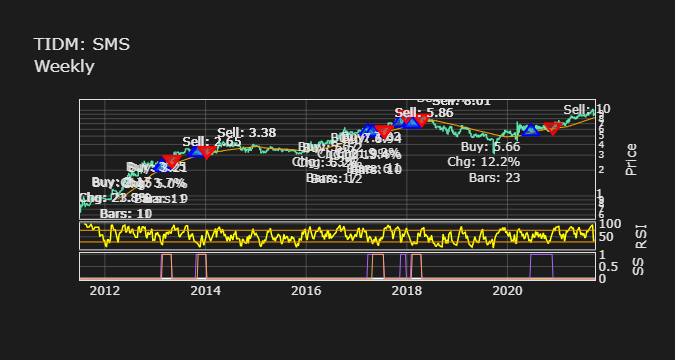

In [17]:
# Customise plot hovertext.
hovertext_ohlc = []
for i in range(len(df.open)):
    hovertext_ohlc.append(
        str(df.index[i].strftime('%Y-%m-%d'))
        + '<br>O: '+ str('{0:.2f}'.format(df.open[i]))
        + '<br>H: '+ str('{0:.2f}'.format(df.high[i]))
        + '<br>L: '+ str('{0:.2f}'.format(df.low[i]))
        + '<br>C: '+ str('{0:.2f}'.format(df.close[i]))
    )

hovertext_sma = []
for i in range(len(df.open)):
    hovertext_sma.append(
    f'{p_sma} SMA: ' + str('{0:.2f}'.format(df.sma[i]))
    )

hovertext_rsi = []
for i in range(len(df.open)):
    hovertext_rsi.append(
        str(df.index[i].strftime('%Y-%m-%d'))
        + f'<br>{p_rsi} RSI: ' + str('{0:.1f}'.format(df.rsi[i]))
    )

hovertext_ss1 = []
for i in range(len(df.open)):
    hovertext_ss1.append(
        str(df.index[i].strftime('%Y-%m-%d'))
        + f'<br>SS1: ' + str('{0:.0f}'.format(df.ss1[i]))
    )
    
hovertext_ss2 = []
for i in range(len(df.open)):
    hovertext_ss2.append(
        f'<br>SS2: ' + str('{0:.0f}'.format(df.ss2[i]))
    )

hovertext_buy = []
for i in range(len(tdm.index)):
    hovertext_buy.append(
    f'Buy: ' + str('{0:.2f}'.format(tdm.entry_price[i]))
    + f'<br>Chg: ' + str('{0:.1f}'.format(tdm.chg_pct[i])) + '%'
    + f'<br>Bars: ' + str('{0:.0f}'.format(tdm.weeks[i]))
    )
    
hovertext_sell = []
for i in range(len(tdm.index)):
    hovertext_sell.append(
    f'Sell: ' + str('{0:.2f}'.format(tdm.exit_price[i]))
    )
    
# Create plot traces.
trace_ohlc = go.Ohlc(
    x=df.index,
    open=df.open,
    high=df.high,
    low=df.low,
    close=df.close,
    increasing_line_color='rgba(92, 230, 174, 1.0)',
    decreasing_line_color='rgba(92, 230, 174, 1.0)',
    line_width=1.5,
    text=hovertext_ohlc,
    hoverinfo='text',
)

trace_sma = go.Scatter(
    x=df.index,
    y=df.sma,
    line=dict(color='orange', width=1.0),
    text=hovertext_sma,
    hoverinfo='text',
)

trace_rsi = go.Scatter(
    x=df.index,
    y=df.rsi,
    line=dict(color='yellow', width=1.5),
    text=hovertext_rsi,
    hoverinfo='text',
)

trace_ss1 = go.Scatter(
    x=df.index,
    y=df.ss1,
    line=dict(width=1.0),
    text=hovertext_ss1,
    hoverinfo='text',
)

trace_ss2 = go.Scatter(
    x=df.index,
    y=df.ss2,
    line=dict(width=1.0),
    text=hovertext_ss2,
    hoverinfo='text',
)

trace_buy = go.Scatter(
    x=tdm.index,
    y=tdm.entry_price,
    name='Buy',
    mode='markers+text',
    marker_symbol='triangle-up',
    marker=dict(
        color='rgba(28, 134, 238, 0.5)',
        size=15,
        line=dict(color='Blue', width=2)
    ),
    text=hovertext_buy,
    textposition='bottom left',
    hoverinfo='text',
)

trace_sell = go.Scatter(
    x=tdm.exit_date,
    y=tdm.exit_price,
    name='Sell',
    mode='markers+text',
    marker_symbol='triangle-down',
    marker=dict(
        color='rgba(238, 44, 44, 0.5)',
        size=15,
        line=dict(color='Red', width=2)
    ),
    text=hovertext_sell,
    textposition='top right',
    hoverinfo='text',
)

# Create figure and add traces.
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02,)
fig.add_trace(trace_ohlc, row=1, col=1)
fig.add_trace(trace_sma, row=1, col=1)
fig.add_trace(trace_rsi, row=2, col=1)
fig.add_hline(y=pz1, row=2, col=1, line=dict(color='orange', width=1.0))
fig.add_hline(y=pze, row=2, col=1, line=dict(color='orange', width=1.0))
fig.add_trace(trace_ss1, row=3, col=1)
fig.add_trace(trace_ss2, row=3, col=1)
fig.add_trace(trace_buy, row=1, col=1)
fig.add_trace(trace_sell, row=1, col=1)

# Customise plot layout.
fig.update_layout(
    autosize=True,
    showlegend=False,
    # width=670,
    # height=500,
    yaxis_domain=[0.34, 1],
    yaxis2_domain=[0.17, 0.32],
    yaxis3_domain=[0, 0.15],
    paper_bgcolor='rgba(28, 28, 28, 1.0)',
    plot_bgcolor='rgba(28, 28, 28, 1.0)',
    font=dict(color='rgba(226, 226, 226, 1.0)'),
    title=dict(
        text=f'TIDM: {tidm}<br>{timeframe}',
        font_color='rgba(226, 226, 226, 1.0)'
    ),
    xaxis=dict(rangeslider=dict(visible=False)),
    hovermode='x unified',
    hoverlabel=dict(bgcolor='rgba(28, 28, 28, 0.8)')
)

# Customise plot axes.
fig.update_xaxes(
    linecolor='rgba(226, 226, 226, 1.0)',
    gridcolor='rgba(119, 119, 119, 0.5)',
    mirror=True,
)

fig.update_yaxes(
    linecolor='rgba(226, 226, 226, 1.0)',
    gridcolor='rgba(119, 119, 119, 0.5)',
    mirror=True,
)

fig.update_yaxes(row=1, col=1, side='right', title='Price', type='log')
fig.update_yaxes(row=2, col=1, side='right', title='RSI')
fig.update_yaxes(row=3, col=1, side='right', title='SS')

# Display plot.
fig.show(
    config={
        'scrollZoom': True,
        'modeBarButtonsToRemove': ['zoom', 'select2d', 'lasso2d'],
    }
)